In [ ]:
# check results from argo

from pystac import Item
from odc.stac import load

jsonpath = "https://dep-public-staging.s3.us-west-2.amazonaws.com/dep_s2_vegheight/0-0-1/023/032/2024/dep_s2_vegheight_023_032_2024.stac-item.json"
item = Item.from_file(jsonpath)
data = load([item])

In [7]:
data

<xarray.Dataset> Size: 369MB
Dimensions:      (y: 9600, x: 9600, time: 1)
Coordinates:
  * y            (y) float64 77kB -8.32e+05 -8.32e+05 ... -9.28e+05 -9.28e+05
  * x            (x) float64 77kB -7.92e+05 -7.92e+05 ... -6.96e+05 -6.96e+05
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 8B 2024-01-01
Data variables:
    height       (time, y, x) float32 369MB 6.137 6.681 6.172 ... nan nan nan

In [ ]:
data.height.odc.explore()

## List missing geomad tiles

In [28]:
from dep_tools.grids import PACIFIC_GRID_10
from dep_tools.searchers import PystacSearcher

grid = PACIFIC_GRID_10
catalog = "https://stac.digitalearthpacific.org"
collection = "dep_s2_geomad"
datetime = '2023'
tile_ids = ["107,8", "108,8", "123,11", "125,12", "130,12", "101,13", "103,13", "118,13", "123,13", "50,14", "51,14", "53,14", "97,14", "115,14", "118,14", "49,15", "50,15", "51,15", "56,15", "70,15", "91,15", "95,15", "99,15", "113,15", "116,15", "41,16", "48,16", "49,16", "50,16", "51,16", "52,16", "67,16", "71,16", "89,16", "111,16", "116,16", "117,16", "47,17", "48,17", "49,17", "50,17", "51,17", "54,17", "67,17", "71,17", "72,17", "92,17", "108,17", "113,17", "114,17", "40,18", "41,18", "46,18", "47,18", "53,18", "54,18", "68,18", "71,18", "72,18", "91,18", "106,18", "111,18", "113,18", "41,19", "46,19", "53,19", "63,19", "64,19", "65,19", "66,19", "67,19", "72,19", "73,19", "77,19", "89,19", "90,19", "110,19", "111,19", "113,19", "116,19", "46,20", "52,20", "62,20", "63,20", "64,20", "65,20", "66,20", "67,20", "72,20", "85,20", "100,20", "101,20", "103,20", "108,20", "109,20", "111,20", "115,20", "116,20", "38,21", "52,21", "62,21", "63,21", "64,21", "65,21", "66,21", "67,21", "96,21", "99,21", "100,21", "101,21", "105,21", "106,21", "107,21", "108,21", "109,21", "110,21", "114,21", "51,22", "52,22", "63,22", "64,22", "65,22", "66,22", "67,22", "95,22", "96,22", "98,22", "99,22", "104,22", "105,22", "106,22", "107,22", "108,22", "109,22", "110,22", "112,22", "50,23", "51,23", "52,23", "66,23", "71,23", "73,23", "95,23", "102,23", "103,23", "104,23", "105,23", "106,23", "107,23", "109,23", "111,23", "112,23", "50,24", "51,24", "52,24", "68,24", "76,24", "102,24", "103,24", "104,24", "105,24", "106,24", "107,24", "113,24", "51,25", "68,25", "74,25", "75,25", "76,25", "78,25", "110,25", "111,25", "50,26", "51,26", "70,26", "74,26", "85,26", "43,27", "53,27", "54,27", "62,27", "32,28", "33,28", "34,28", "35,28", "36,28", "42,28", "43,28", "50,28", "54,28", "76,28", "82,28", "98,28", "28,29", "29,29", "30,29", "31,29", "32,29", "33,29", "34,29", "44,29", "45,29", "49,29", "50,29", "65,29", "82,29", "88,29", "20,30", "21,30", "22,30", "27,30", "28,30", "29,30", "30,30", "31,30", "32,30", "33,30", "34,30", "35,30", "42,30", "43,30", "44,30", "45,30", "49,30", "51,30", "65,30", "75,30", "76,30", "87,30", "100,30", "112,30", "113,30", "20,31", "21,31", "22,31", "23,31", "24,31", "26,31", "27,31", "28,31", "29,31", "30,31", "31,31", "32,31", "33,31", "34,31", "39,31", "40,31", "41,31", "42,31", "43,31", "44,31", "46,31", "64,31", "65,31", "74,31", "75,31", "91,31", "111,31", "112,31", "113,31", "20,32", "21,32", "22,32", "23,32", "24,32", "25,32", "26,32", "27,32", "28,32", "29,32", "31,32", "32,32", "38,32", "39,32", "40,32", "41,32", "42,32", "43,32", "64,32", "111,32", "20,33", "21,33", "22,33", "23,33", "24,33", "25,33", "26,33", "27,33", "28,33", "37,33", "38,33", "39,33", "40,33", "41,33", "62,33", "64,33", "20,34", "21,34", "22,34", "23,34", "24,34", "25,34", "26,34", "27,34", "28,34", "29,34", "30,34", "31,34", "32,34", "36,34", "37,34", "38,34", "61,34", "62,34", "20,35", "21,35", "22,35", "23,35", "24,35", "25,35", "26,35", "27,35", "28,35", "29,35", "30,35", "31,35", "32,35", "33,35", "36,35", "37,35", "41,35", "42,35", "61,35", "93,35", "94,35", "20,36", "21,36", "22,36", "23,36", "24,36", "25,36", "26,36", "30,36", "32,36", "33,36", "34,36", "35,36", "36,36", "37,36", "39,36", "42,36", "72,36", "75,36", "76,36", "95,36", "20,37", "21,37", "22,37", "23,37", "24,37", "25,37", "33,37", "34,37", "35,37", "36,37", "72,37", "75,37", "76,37", "95,37", "20,38", "21,38", "22,38", "26,38", "27,38", "28,38", "30,38", "31,38", "32,38", "33,38", "34,38", "36,38", "61,38", "62,38", "75,38", "76,38", "22,39", "23,39", "24,39", "25,39", "26,39", "27,39", "28,39", "29,39", "30,39", "31,39", "32,39", "60,39", "23,40", "24,40", "25,40", "26,40", "30,40", "53,40", "59,40", "60,40", "61,40", "50,41", "58,41", "59,41", "36,42", "57,42", "58,42", "59,42", "57,43", "58,43", "92,43", "58,44", "92,44", "9,45", "10,45", "57,45", "10,46", "36,46", "37,46", "52,46", "53,46", "89,46", "90,46", "10,47", "35,47", "46,47", "52,47", "53,47", "88,47", "34,48", "35,48", "39,48", "43,48", "52,48", "53,48", "54,48", "56,48", "12,49", "13,49", "23,49", "30,49", "33,49", "34,49", "40,49", "42,49", "55,49", "56,49", "13,50", "24,50", "26,50", "27,50", "30,50", "33,50", "36,50", "37,50", "52,50", "53,50", "55,50", "56,50", "13,51", "16,51", "20,51", "24,51", "27,51", "28,51", "30,51", "31,51", "32,51", "33,51", "36,51", "49,51", "50,51", "51,51", "52,51", "55,51", "17,52", "19,52", "20,52", "25,52", "31,52", "43,52", "49,52", "50,52", "51,52", "54,52", "19,53", "43,53", "49,53", "53,53", "54,53", "55,53", "45,54", "49,54", "50,54", "51,54", "54,54", "45,55", "48,55", "49,55", "54,55", "25,57", "25,58", "26,58", "53,58", "26,59", "26,60", "26,61", "26,62", "26,63", "25,64", "25,65"]

In [29]:
searcher = PystacSearcher(
        catalog=catalog,
        collections=[collection],
        datetime=datetime,
    )

In [30]:
missing_ids = []
for tile_id in tile_ids:
    tile_index = tuple(int(i) for i in tile_id.split(","))
    geobox = grid.tile_geobox(tile_index)
    item_collection = searcher.search(geobox)
    if len(item_collection) == 0:
        missing_ids.append(tile_id)
print(len(tile_ids), len(missing_ids))

517 0


In [31]:
print(*missing_ids)

2017: 150 missing tiles:
107,8 108,8 123,11 125,12 130,12 101,13 103,13 118,13 123,13 97,14 115,14 118,14 91,15 95,15 99,15 113,15 116,15 89,16 111,16 116,16 117,16 92,17 108,17 113,17 114,17 91,18 106,18 111,18 113,18 89,19 90,19 110,19 111,19 113,19 116,19 85,20 108,20 109,20 111,20 115,20 116,20 38,21 107,21 108,21 109,21 110,21 114,21 104,22 105,22 106,22 107,22 108,22 109,22 110,22 112,22 103,23 104,23 105,23 106,23 107,23 109,23 111,23 112,23 102,24 103,24 104,24 105,24 106,24 107,24 113,24 110,25 111,25 85,26 62,27 82,28 65,29 82,29 65,30 75,30 76,30 87,30 74,31 75,31 61,34 61,35 72,36 75,36 76,36 72,37 75,37 76,37 61,38 62,38 75,38 76,38 60,39 53,40 59,40 60,40 61,40 58,41 59,41 36,42 57,42 58,42 59,42 57,43 58,43 58,44 10,45 10,46 36,46 37,46 89,46 90,46 10,47 35,47 88,47 34,48 35,48 23,49 30,49 33,49 34,49 24,50 26,50 27,50 30,50 33,50 36,50 20,51 24,51 27,51 28,51 30,51 31,51 32,51 33,51 36,51 17,52 19,52 20,52 25,52 31,52 19,53 26,61 26,62 26,63 25,64 25,65

2018: 144 missing tiles:
107,8 108,8 101,13 103,13 118,13 97,14 115,14 118,14 91,15 95,15 99,15 113,15 116,15 89,16 111,16 116,16 117,16 92,17 108,17 113,17 114,17 91,18 106,18 111,18 113,18 89,19 90,19 110,19 111,19 113,19 116,19 85,20 108,20 109,20 111,20 115,20 116,20 38,21 107,21 108,21 109,21 110,21 114,21 105,22 106,22 107,22 108,22 109,22 110,22 112,22 103,23 104,23 105,23 106,23 107,23 109,23 111,23 112,23 102,24 103,24 104,24 105,24 106,24 107,24 113,24 110,25 111,25 85,26 62,27 82,28 65,29 82,29 65,30 75,30 76,30 87,30 74,31 75,31 61,34 61,35 72,36 75,36 76,36 72,37 75,37 76,37 61,38 62,38 75,38 76,38 60,39 53,40 59,40 60,40 61,40 58,41 59,41 36,42 57,42 58,42 59,42 57,43 58,43 58,44 10,45 10,46 36,46 37,46 89,46 90,46 10,47 35,47 88,47 34,48 35,48 23,49 30,49 33,49 34,49 24,50 26,50 27,50 30,50 33,50 36,50 20,51 24,51 27,51 28,51 30,51 31,51 32,51 33,51 36,51 19,52 20,52 25,52 31,52 19,53 26,61 26,62 26,63 25,64 25,65

2019: 57 missing tiles:
38,21 85,26 62,27 82,28 82,29 75,30 76,30 87,30 74,31 75,31 72,36 75,36 76,36 72,37 75,37 76,37 75,38 76,38 53,40 36,42 36,46 37,46 89,46 90,46 35,47 88,47 34,48 35,48 23,49 30,49 33,49 34,49 24,50 26,50 27,50 30,50 33,50 36,50 20,51 24,51 27,51 28,51 30,51 31,51 32,51 33,51 36,51 19,52 20,52 25,52 31,52 19,53 26,61 26,62 26,63 25,64 25,65

2020: 60 missing tiles:
38,21 85,26 62,27 82,28 82,29 75,30 76,30 87,30 74,31 75,31 72,36 75,36 76,36 72,37 75,37 76,37 75,38 76,38 53,40 36,42 10,45 10,46 36,46 37,46 89,46 90,46 10,47 35,47 88,47 34,48 35,48 23,49 30,49 33,49 34,49 24,50 26,50 27,50 30,50 33,50 36,50 20,51 24,51 27,51 28,51 30,51 31,51 32,51 33,51 36,51 19,52 20,52 25,52 31,52 19,53 26,61 26,62 26,63 25,64 25,65

2021: 60 missing tiles:
38,21 85,26 62,27 82,28 82,29 75,30 76,30 87,30 74,31 75,31 72,36 75,36 76,36 72,37 75,37 76,37 75,38 76,38 53,40 36,42 10,45 10,46 36,46 37,46 89,46 90,46 10,47 35,47 88,47 34,48 35,48 23,49 30,49 33,49 34,49 24,50 26,50 27,50 30,50 33,50 36,50 20,51 24,51 27,51 28,51 30,51 31,51 32,51 33,51 36,51 19,52 20,52 25,52 31,52 19,53 26,61 26,62 26,63 25,64 25,65




# Import

In [1]:
from dep_tools.searchers import PystacSearcher
from dep_tools.loaders import OdcLoader
import src.utils as utils

from dep_tools.grids import PACIFIC_GRID_10
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

print("CUDA available:", torch.cuda.is_available())

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA available: True


In [2]:
from importlib import reload

reload(utils)

<module 'src.utils' from '/data/dep-veg/code/src/utils.py'>

In [3]:
def resize_figure(fig, factor=2):
    return fig.set_size_inches(*(fig.get_size_inches() * factor))


def imshow(
    im, fig=None, ax=None, alpha=1, cmap=None, label="", return_true=False, resize=False
):
    """
    im: np array [c,h,w], value range from 0 to 255
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    if torch.is_tensor(im):
        im = im.detach().cpu().numpy()

    # if im.max() <= 1:
    #     im = im * 255

    im = im.astype(np.uint8)
    if im.shape[0] == 3:  # if is an RGB image, not a mask
        if ax is None:
            fig, ax = plt.subplots(1, 1)
        ax.imshow(im.transpose([1, 2, 0]))
    else:  # if a mask
        if len(im.shape) == 2:
            im = im[None]
        if ax is None:
            fig, ax = plt.subplots(1, len(im))
        if len(im) == 1:
            f = ax.imshow(im[0], alpha=alpha, cmap=cmap)
            divider = make_axes_locatable(ax)
            # if 1 in im.shape: # add a colorbar
            cax = divider.append_axes("right", size="7%", pad=0.05)
            fig.colorbar(f, cax=cax, ax=ax)
            fig.tight_layout()
            ax.set_title(label)
        else:
            for i in range(im.shape[0]):
                f = ax[i].imshow(im[i], alpha=alpha, cmap=cmap)
                ax[i].axis("off")
                divider = make_axes_locatable(ax[i])
                # if 1 in im.shape: # add a colorbar
                cax = divider.append_axes("right", size="7%", pad=0.05)
                fig.colorbar(f, cax=cax, ax=ax[i])
                fig.tight_layout()
                ax[i].set_title(label + " " + str(i))

    if resize:
        resize_figure(fig, resize)
    if return_true:
        return fig, ax

# test download a tile

In [1]:
from dep_tools.searchers import PystacSearcher
from dep_tools.loaders import OdcLoader
import src.utils as utils

from dep_tools.grids import PACIFIC_GRID_10
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

print("CUDA available:", torch.cuda.is_available())

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA available: True


In [ ]:
import os
from dotenv import load_dotenv

load_dotenv('.env')  # finds .env automatically

print(os.environ["GDAL_HTTP_TCP_KEEPALIVE"])
print(os.environ["AWS_S3_ENDPOINT"])# = "eodata.dataspace.copernicus.eu" # doulbe check this for me

# Uncomment the following lines if you need to set AWS credentials otherwise will come from user dir or envfile above
# Otherwise coming from envfile
print(os.environ["AWS_ACCESS_KEY_ID"])#
print(os.environ["AWS_SECRET_ACCESS_KEY"])
print(os.environ["AWS_HTTPS"])# = "YES"
print(os.environ["AWS_VIRTUAL_HOSTING"])# = "FALSE"
print(os.environ["GDAL_HTTP_UNSAFESSL"])# = "YES"


In [3]:

import boto3
# from botocore.config import Config
from rasterio.session import AWSSession
import rasterio as rio
# from pathlib import Path
session = boto3.Session(profile_name='copernicus')
aws = AWSSession(
    session
)


In [4]:
def normalize_rgb_to_uint8(rgb):
    """
    Normalize a float32 RGB array to the range [0, 255] and convert to uint8.
    rgb: np.ndarray of shape (3, H, W), dtype float32
    Returns: np.ndarray of shape (3, H, W), dtype uint8
    """
    rgb_min = 0.1
    rgb_max = np.quantile(rgb, 0.99)
    # Avoid division by zero
    if rgb_max == rgb_min:
        norm_rgb = np.zeros_like(rgb, dtype=np.uint8)
    else:
        norm_rgb = ((rgb - rgb_min) / (rgb_max - rgb_min) * 255).clip(0, 255).astype(np.uint8)
    return norm_rgb

# Extract metadata from the xarray Dataset 'data' for saving as raster
def extract_raster_meta(data):
    """
    Extracts raster metadata from an xarray Dataset for rasterio saving.
    Returns a dictionary with keys: dtype, crs, transform, count, height, width.
    """
    # Use the first band for shape and dtype
    band = list(data.data_vars)[0]
    arr = data[band]
    dtype = str(arr.dtype)
    height, width = arr.shape[-2], arr.shape[-1]
    # Get CRS and transform from geobox if available
    crs = data.spatial_ref if hasattr(data, "spatial_ref") else None
    if hasattr(data, "odc") and hasattr(data.odc, "transform"):
        transform = data.odc.transform
    elif hasattr(data, "transform"):
        transform = data.transform
    else:
        transform = None
    # Try to get CRS string
    if hasattr(data, "odc") and hasattr(data.odc, "crs"):
        crs = data.odc.crs
    elif hasattr(data, "crs"):
        crs = data.crs
    elif hasattr(data, "spatial_ref"):
        crs = data.spatial_ref
    meta = {
        "dtype": dtype,
        "crs": str(crs) if crs is not None else None,
        "transform": transform,
        # "count": arr.shape[0] if arr.ndim == 3 else 1,  # number of channels
        # "height": height,
        # "width": width,
    }
    return meta

def save_raster(a, meta, save_path, nbits=8, overwrite=False, **kwargs):
    '''
    a: np array [c,h,w] or [h,w] 
    meta: dict
    save_path: ends with .tif
    nbits: number of bits to store each pixel. This is very helpful to compress the raster if the value range is small.
    overwrite: option to overwrite existing files
    '''
    save_path = Path(save_path)
    save_path_exists = save_path.exists()
    if save_path_exists:
        print(f'file exists: {save_path}')
        if not overwrite:
            raise Exception(f'file exists: {save_path} and overwrite is set to False. Please set overwrite to True')
        print(f'Overwriting file...')
    if len(a.shape) == 2:
        a = a[None] #ensure a.shape = [c,h,w]
    meta['count'] = a.shape[0]
    meta['height'] = a.shape[1]
    meta['width'] = a.shape[2]
    meta['dtype'] = a.dtype
    try:
        with rio.open(save_path, 'w', nbits=nbits, **meta, **kwargs) as dest:
            for i in range(a.shape[0]):
                dest.write(a[i], i+1)
    except Exception as e:
        raise Exception(f'Error saving raster to {save_path} error {e}. Check the meta and data shape. Meta: {meta}, data shape: {a.shape}')

def load_raster(raster_path):
    """
    Load a raster file as a numpy array and return array and metadata.
    Returns:
        arr: np.ndarray
        meta: dict (rasterio metadata)
    """
    raster_path = str(raster_path)
    with rasterio.open(raster_path) as src:
        arr = src.read()
        meta = src.meta.copy()
    return arr, meta


#----------------------------------------landmask utils--------------------------------
import io
import os
import tempfile
import zipfile
from pathlib import Path

import numpy as np
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
from shapely.geometry import box
from pyproj import CRS, Transformer
import requests


LAND_POLYGONS_URL = "https://osmdata.openstreetmap.de/download/land-polygons-complete-4326.zip"

def download_and_extract_land_polygons(url: str = LAND_POLYGONS_URL,
                                       out_dir: str | Path = "land_polygons") -> Path:
    """
    Download the OSM land polygons zip and extract it to `out_dir`.
    Returns the path to the main .shp file.
    """
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    # Find shapefile
    shp_files = list(out_dir.rglob("*.shp"))
    if not shp_files:
        # Download
        resp = requests.get(url)
        resp.raise_for_status()

        # Extract
        with zipfile.ZipFile(io.BytesIO(resp.content)) as zf:
            zf.extractall(out_dir)

        shp_files = list(out_dir.rglob("*.shp"))
        if not shp_files:
            raise FileNotFoundError("No .shp file found in extracted land polygons.")
    # Usually it's named 'land_polygons.shp', but we just take the first
    return shp_files[0]

def geobox_raster_transform(geobox):
    """
    Get rasterio-compatible transform and shape from a GeoBox.
    Works with datacube GeoBox.
    """
    # GeoBox usually has .affine and .shape, newer versions also .transform
    transform = getattr(geobox, "transform", getattr(geobox, "affine"))
    height, width = geobox.shape  # (rows, cols)
    return transform, (height, width)


def geobox_bounds_in_crs(geobox, target_crs="EPSG:4326"):
    """
    Get bounding box of GeoBox transformed into target_crs.
    Returns (minx, miny, maxx, maxy) in target_crs.
    """
    # GeoBox extent is in its own CRS
    extent = geobox.extent  # datacube geometry with .boundingbox
    left, bottom, right, top = extent.boundingbox

    src_crs = CRS.from_user_input(geobox.crs)
    dst_crs = CRS.from_user_input(target_crs)
    transformer = Transformer.from_crs(src_crs, dst_crs, always_xy=True)

    # Transform corners (approx; good for moderate-sized areas)
    minx, miny = transformer.transform(left, bottom)
    maxx, maxy = transformer.transform(right, top)

    # Ensure ordering is correct
    minx, maxx = min(minx, maxx), max(minx, maxx)
    miny, maxy = min(miny, maxy), max(miny, maxy)
    return minx, miny, maxx, maxy

def rasterize_land_mask_for_geobox(geobox,
                                   land_shp_path: str | Path,
                                   all_touched: bool = False) -> np.ndarray:
    """
    Given a GeoBox (in EPSG:3832) and a path to the OSM land polygons shapefile
    (in EPSG:4326), return a rasterized mask aligned to the GeoBox:

        - 1 where land intersects the GeoBox
        - 0 elsewhere

    Returns: numpy.ndarray of shape (geobox.height, geobox.width), dtype uint8.
    """
    land_shp_path = Path(land_shp_path)

    # 1) Compute bounding box of geobox in EPSG:4326 to efficiently subset polygons
    bbox_4326 = geobox_bounds_in_crs(geobox, target_crs="EPSG:4326")

    # 2) Read only polygons intersecting this bbox (still in 4326)
    land = gpd.read_file(land_shp_path, bbox=bbox_4326)

    if land.empty:
        # No land polygons intersect this geobox: return all zeros
        _, (height, width) = geobox_raster_transform(geobox)
        return np.zeros((height, width), dtype=np.uint8)

    # 3) Reproject polygons to the GeoBox CRS (EPSG:3832)
    land = land.to_crs(geobox.crs)

    # 4) Clip polygons to the GeoBox's exact extent in its CRS (for efficiency)
    extent = geobox.extent
    left, bottom, right, top = extent.boundingbox
    geobox_poly = box(left, bottom, right, top)

    land["geometry"] = land.geometry.intersection(geobox_poly)
    land = land[~land.geometry.is_empty & land.geometry.notnull()]

    if land.empty:
        _, (height, width) = geobox_raster_transform(geobox)
        return np.zeros((height, width), dtype=np.uint8)

    # 5) Rasterize
    transform, (height, width) = geobox_raster_transform(geobox)

    shapes = ((geom, 1) for geom in land.geometry if not geom.is_empty)

    mask = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype="uint8",
        all_touched=all_touched,
    )

    return mask

def save_mask_as_geotiff(mask, geobox, out_path):
    """
    Save the mask (2D numpy array) as a GeoTIFF aligned to the GeoBox.
    """
    
    import rasterio
    from rasterio.crs import CRS
    
    transform = getattr(geobox, "transform", getattr(geobox, "affine"))
    crs = CRS.from_user_input(geobox.crs)

    height, width = mask.shape

    with rasterio.open(
        out_path,
        "w",
        driver="GTiff",
        height=height,
        width=width,
        count=1,
        dtype=mask.dtype,
        crs=crs,
        transform=transform,
        compress="deflate",
    ) as dst:
        dst.write(mask, 1)

    print(f"Saved mask raster → {out_path}")

# def distance_map_bfs(binary_img: np.ndarray, landmask:np.ndarray) -> np.ndarray:
#     """
#     Compute Manhattan distance to nearest 1-pixel using multi-source BFS.

#     Args:
#         binary_img: 2D numpy array of shape (h, w). Nonzero treated as 1.

#     Returns:
#         dist: 2D numpy array of shape (h, w), dtype=int32.
#               dist[y, x] = min # of 4-neighbor steps to any 1-pixel.
#               If there are no 1-pixels, returns an array filled with h+w (a safe upper bound).
#     """
#     import numpy as np
#     from collections import deque
#     from tqdm.auto import tqdm

#     if binary_img.ndim != 2:
#         raise ValueError("binary_img must be a 2D array")

#     h, w = binary_img.shape
#     ones = (binary_img != 0)

#     # distance initialized to -1 (unvisited)
#     distx = np.full((h, w), -1, dtype=np.int32)
#     disty = np.full((h, w), -1, dtype=np.int32)
#     q = deque()

#     distx[landmask==0] = h+w
#     disty[landmask==0] = h+w
#     ones[landmask==0] = 0
#     # Initialize queue with all 1-pixels (multi-source BFS)
#     ys, xs = np.nonzero(ones)
    
#     for y, x in zip(ys, xs):
#         distx[y, x] = 0
#         disty[y, x] = 0
#         q.append((y, x))
#     count = len(q)
#     # Edge case: no 1s in input
#     if not q:
#         # You can also choose np.inf here, but int upper bound is sometimes nicer.
#         print('all pixels=1')
#         return np.full((h, w), h + w, dtype=np.int32)

#     # 4-neighbor BFS
#     neighbors = ((1, 0), (-1, 0), (0, 1), (0, -1))
#     pbar = tqdm(total=landmask.sum(), desc="BFS progress")
#     pbar.update(count)
#     while q:
#         # print(count)
#         y, x = q.popleft()
#         for dy, dx in neighbors:
#             ny, nx = y + dy, x + dx
#             if 0 <= ny < h and 0 <= nx < w and distx[ny, nx] == -1:
#                 distx[ny, nx] = distx[y, x] + abs(dx)
#                 disty[ny, nx] = disty[y, x] + abs(dy)
#                 # print(distx[ny, nx].max(), disty[ny,nx].max())
#                 q.append((ny, nx))
#                 count += 1
#                 pbar.update(1)
                    
#     return distx, disty



In [5]:
from importlib import reload
reload(utils)

<module 'src.utils' from '/data/dep-veg/code/src/utils.py'>

In [ ]:

# run cloudless mosaic
catalog = "https://stac.dataspace.copernicus.eu/v1"
collection = "sentinel-2-global-mosaics"
# tile_id = (130, 12)  # Tiny island
# tile_id = (104, 23)  # Another noisy island
# tile_id = (66, 22)  # noise near Eastern Vanua Levu. Still BAD
# tile_id = (48, 18)  # NW of New Caledonia
# tile_id = (64, 20)  # Suva
# tile_id = (63, 21), (63, 20) # Fiji west
# tile_id = (64, 21), (64, 20) # Fiji east

# tile_id = (21, 35) # a very cloudy mountain far west of fiji (worst case with cloud)
# tile_ids = [(63, 21), (63, 20), (64, 21), (64, 20)]
tile_ids = [(63, 21)]
# tile_ids = [(63, 20), (64, 21), (64, 20)]

# datetime = "2024"  # "2025-01"
datetime = "2024-07-01"
# datetimes = ["2024"]

# processor = utils.VegProcessor()
processor = utils.VegProcessorKeepNonVegPixels()
for tile_id in tile_ids:
    print(tile_id)
    geobox = PACIFIC_GRID_10.tile_geobox(tile_id)

    searcher = PystacSearcher(
        catalog=catalog,
        collections=[collection],
        datetime=datetime,
    )

    loader = OdcLoader(
        bands=["B04", "B03", "B02", 'observations'],#, "B08"],
        chunks={"x": 1024, "y": 1024}
    )

    items = searcher.search(geobox)

    print(f"Found {len(items)} items")

    data = loader.load(items, geobox)
    meta = extract_raster_meta(data)
    height, confidence = processor.process(data)
    
    savestem = f"cloudless_{str(tile_id).replace(',', '_')}_{datetime.replace('-','')}_land"
    
    save_raster(processor.img, meta, save_path =Path(f'/data/{savestem}.tif'), nbits=8, overwrite=True)
    save_raster(processor.mask.astype('uint8'), meta, save_path =Path(f'/data/landmask_{savestem}.tif'), nbits=8, overwrite=True)
    save_raster(height, meta, save_path =Path(f'/data/height_{savestem}.tif'), nbits=None, overwrite=True)
    save_raster(confidence, meta, f'/data/conf_{savestem}.tif', overwrite=True)



In [ ]:
from scipy.ndimage import uniform_filter

# run cloudless mosaic
catalog = "https://stac.dataspace.copernicus.eu/v1"
collection = "sentinel-2-global-mosaics"

land_shp = download_and_extract_land_polygons()

# tile_id = (130, 12)  # Tiny island
# tile_id = (104, 23)  # Another noisy island
# tile_id = (66, 22)  # noise near Eastern Vanua Levu. Still BAD
# tile_id = (48, 18)  # NW of New Caledonia
# tile_id = (64, 20)  # Suva
# tile_id = (63, 21), (63, 20) # Fiji west
# tile_id = (64, 21), (64, 20) # Fiji east

# tile_id = (21, 35) # a very cloudy mountain far west of fiji (worst case with cloud)
# tile_ids = [(63, 21), (63, 20), (64, 21), (64, 20)]
tile_ids = [(63, 21)]
# tile_ids = [(63, 20), (64, 21), (64, 20)]

# datetime = "2024"  # "2025-01"
datetime = "2024-07-01"
# datetimes = ["2024"]

# processor = utils.VegProcessor()
processor = utils.VegProcessorKeepNonVegPixels()
for tile_id in tile_ids:
    print(tile_id)
    geobox = PACIFIC_GRID_10.tile_geobox(tile_id)
    landmask = rasterize_land_mask_for_geobox(geobox, land_shp) # [9600,9600]

    searcher = PystacSearcher(
        catalog=catalog,
        collections=[collection],
        datetime=datetime,
    )

    loader = OdcLoader(
        bands=["B04", "B03", "B02", 'observations'],#, "B08"],
        chunks={"x": 1024, "y": 1024}
    )

    items = searcher.search(geobox)

    print(f"Found {len(items)} items")

    data = loader.load(items, geobox)
    meta = extract_raster_meta(data)
    # extract bands B04, B03, B02 into an RGB image
    rgb = np.stack(
            [
                data["B04"].values.squeeze(),  # Red
                data["B03"].values.squeeze(),  # Green
                data["B02"].values.squeeze(),  # Blue
            ],
            axis=0,
        )
    height = processor.process(rgb)
    
    savestem = f"cloudless_{str(tile_id).replace(',', '_')}_{datetime.replace('-','')}_land"
    
    save_raster(rgb, meta, f'/data/rawim_{savestem}.tif', overwrite=True)
    save_raster(processor.img, meta, save_path =Path(f'/data/{savestem}.tif'), nbits=8, overwrite=True)
    save_raster(processor.mask.astype('uint8'), meta, save_path =Path(f'/data/landmask_{savestem}.tif'), nbits=8, overwrite=True)
    meta['dtype'] = 'float32'
    save_raster(height, meta, save_path =Path(f'/data/height_{savestem}.tif'), nbits=None, overwrite=True)

    # working on confidence map
    obs = data['observations'].values[0] #[h,w]
    obs = np.nan_to_num(obs, nan=0) #set no-observation from nan to 0
    # Compute local average with a 101x101 kernel
    # confidence = uniform_filter(obs, size=51, mode='constant', cval=0)
    confidence = uniform_filter(obs, size=51, mode='reflect')
    confidence = confidence.clip(max=10)/10 * processor.mask.astype('uint8')
    obs *= processor.mask.astype('uint8') # non-land pixels set to 0 observation
    save_raster(confidence, meta, f'/data/conf_{savestem}.tif', overwrite=True)
    save_raster(obs, meta, f'/data/obs_{savestem}.tif', overwrite=True)
    



(63, 20)
Found 4 items


In [10]:
data

<xarray.Dataset> Size: 1GB
Dimensions:       (y: 9600, x: 9600, time: 1)
Coordinates:
  * y             (y) float64 77kB -1.984e+06 -1.984e+06 ... -2.08e+06 -2.08e+06
  * x             (x) float64 77kB 3.048e+06 3.048e+06 ... 3.144e+06 3.144e+06
    spatial_ref   int32 4B 3832
  * time          (time) datetime64[ns] 8B 2024-04-01
Data variables:
    B04           (time, y, x) float32 369MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B03           (time, y, x) float32 369MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B02           (time, y, x) float32 369MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    observations  (time, y, x) float32 369MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>

In [ ]:
# run cloudless mosaic
catalog = "https://stac.dataspace.copernicus.eu/v1"
collection = "sentinel-2-global-mosaics"

land_shp = download_and_extract_land_polygons()

# tile_id = (130, 12)  # Tiny island
# tile_id = (104, 23)  # Another noisy island
# tile_id = (66, 22)  # noise near Eastern Vanua Levu. Still BAD
# tile_id = (48, 18)  # NW of New Caledonia
# tile_id = (64, 20)  # Suva
# tile_id = (63, 21), (63, 20) # Fiji west
# tile_id = (64, 21), (64, 20) # Fiji east

# tile_id = (21, 35) # a very cloudy mountain far west of fiji (worst case with cloud)
# tile_ids = [(63, 21), (63, 20), (64, 21), (64, 20)]
tile_ids = [(63, 21)]
# datetime = "2024"  # "2025-01"
datetime = "2024-04-01"
# datetimes = ["2024"]

# processor = utils.VegProcessor()
processor = utils.VegProcessorKeepNonVegPixels()
for tile_id in tile_ids:
    print(tile_id)
    geobox = PACIFIC_GRID_10.tile_geobox(tile_id)
    landmask = rasterize_land_mask_for_geobox(geobox, land_shp) # [9600,9600]

    searcher = PystacSearcher(
        catalog=catalog,
        collections=[collection],
        datetime=datetime,
    )

    loader = OdcLoader(
        bands=["B04", "B03", "B02", 'observations'],#, "B08"],
        chunks={"x": 1024, "y": 1024}
    )

    items = searcher.search(geobox)

    print(f"Found {len(items)} items")

    data = loader.load(items, geobox)
    meta = extract_raster_meta(data)
    
    savestem = f"cloudless_{str(tile_id).replace(',', '_')}_{datetime.replace('-','')}_uselandmask"
    
    meta['dtype'] = 'uint8'
    img, _ = load_raster(f'/data/{savestem}.tif')
    # save_raster(processor.img, meta, save_path =Path(f'/data/{savestem}.tif'), nbits=8, overwrite=True)
    # save_raster(processor.landmask.astype('uint8'), meta, save_path =Path(f'/data/landmask_{savestem}.tif'), nbits=8, overwrite=True)
    # meta['dtype'] = 'float32'
    # save_raster(height, meta, save_path =Path(f'/data/height_{savestem}.tif'), nbits=None, overwrite=True)

    # working on confidence map
    obs = data['observations'].values[0] #[h,w]
    obs = np.nan_to_num(obs, nan=0) #set no-observation from nan to 0
    # get a crude cloud mask, and set obs at those cloud pixels to 0 too
    # crude_cloudmask = np.where(img[1].astype('int64') + img[2].astype('int64') > 400, 0, 1).astype('uint8') 
    # crude_cloudmask = cv2.erode(crude_cloudmask, np.ones((5, 5), np.uint8), iterations=1)
    # crude_cloudmask = cv2.dilate(crude_cloudmask, np.ones((5, 5), np.uint8), iterations=1)
    # obs_with_cloudmask = obs * crude_cloudmask

    no_obs_mask = (obs==0).astype('uint8')  
    no_obs_mask = cv2.erode(crude_cloudmask, np.ones((5, 5), np.uint8), iterations=1)
    crude_cloudmask = cv2.dilate(crude_cloudmask, np.ones((5, 5), np.uint8), iterations=1)
    # 
    dy, dx = distance_map_bfs(no_obs_mask, landmask)
    distance_to_nearest_no_obs = np.sqrt(dx**2+dy**2).clip(max=100)/100 * landmask

    confidence = obs.clip(max=5)/5 * landmask *0.5 + distance_to_nearest_no_obs*0.5
    
    save_raster(distance_to_nearest_no_obs, meta, f'/data/distance_from_no_obs_{savestem}.tif', overwrite=True)
    save_raster(confidence, meta, f'/data/conf_{savestem}.tif', overwrite=True)
    # save_raster(obs_with_cloudmask, meta, f'/data/obs_with_cloudmask_{savestem}.tif', overwrite=True)
    # save_raster(crude_cloudmask, meta, f'/data/simple_cloudmask_{savestem}.tif', overwrite=True)
    save_raster(obs.clip(max=5)/5, meta, f'/data/obs_{savestem}.tif', overwrite=True)
    



(63, 21)
Found 4 items


BFS progress:  98%|█████████▊| 23302322/23815584 [01:38<00:02, 237587.07it/s]


file exists: /data/distance_from_no_obs_cloudless_(63_ 21)_20240401_uselandmask.tif
Overwriting file...
file exists: /data/conf_cloudless_(63_ 21)_20240401_uselandmask.tif
Overwriting file...
file exists: /data/obs_cloudless_(63_ 21)_20240401_uselandmask.tif
Overwriting file...


In [83]:
landmask.min()

np.uint8(0)

In [ ]:
# run geomad
catalog = "https://stac.digitalearthpacific.org"
collection = "dep_s2_geomad"
# catalog = "https://stac.dataspace.copernicus.eu/v1"
# collection = "sentinel-2-global-mosaics"

# tile_id = (130, 12)  # Tiny island
# tile_id = (104, 23)  # Another noisy island
# tile_id = (66, 22)  # noise near Eastern Vanua Levu. Still BAD
# tile_id = (48, 18)  # NW of New Caledonia
# tile_id = (64, 20)  # Suva
# tile_id = (63, 21), (63, 20) # Fiji west
# tile_id = (64, 21), (64, 20) # Fiji east

# tile_id = (21, 35) # a very cloudy mountain far west of fiji (worst case with cloud)
tile_ids = [(63, 21), (63, 20), (64, 21), (64, 20)]
# datetimes = ["2024"]

processor = utils.VegProcessor()

for tile_id in tile_ids:
    print(tile_id)
    geobox = PACIFIC_GRID_10.tile_geobox(tile_id)
    # datetime = "2024"  # "2025-01"
    datetime = "2024-07-01"

    searcher = PystacSearcher(
        catalog=catalog,
        collections=[collection],
        datetime=datetime,
    )

    loader = OdcLoader(
        bands=["red", "green", "blue"],
        # bands=["B04", "B03", "B02"],#, "B08"],
        chunks={"x": 1024, "y": 1024}
    )

    items = searcher.search(geobox)

    print(f"Found {len(items)} items")

    data = loader.load(items, geobox)
    meta = extract_raster_meta(data)
    # extract bands B04, B03, B02 into an RGB image
    rgb = np.stack(
        [
            data["red"].values.squeeze(),  # Red
            data["green"].values.squeeze(),  # Green
            data["blue"].values.squeeze(),  # Blue
        ],
        axis=0,
    )
    # rgb = np.stack(
    #         [
    #             data["B04"].values.squeeze(),  # Red
    #             data["B03"].values.squeeze(),  # Green
    #             data["B02"].values.squeeze(),  # Blue
    #         ],
    #         axis=0,
    #     )
    height = processor.process(rgb)
    # mask = processor.mask
    
    # savestem = f"cloudless_{str(tile_id).replace(',', '_')}_{datetime.replace('-','')}"
    savestem = f"geomad_{str(tile_id).replace(',', '_')}_{datetime.replace('-','')}"
    
    meta['dtype'] = 'uint8'
    save_raster(processor.img, meta, save_path =Path(f'/data/{savestem}.tif'), nbits=8, overwrite=True)
    meta['dtype'] = 'float32'
    save_raster(height, meta, save_path =Path(f'/data/height_{savestem}.tif'), nbits=None, overwrite=True)



In [30]:
# catalog = "https://stac.digitalearthpacific.org"
# collection = "dep_s2_geomad"
catalog = "https://stac.dataspace.copernicus.eu/v1"
collection = "sentinel-2-global-mosaics"

land_shp = download_and_extract_land_polygons()


# tile_id = (130, 12)  # Tiny island
# tile_id = (104, 23)  # Another noisy island
# tile_id = (66, 22)  # noise near Eastern Vanua Levu. Still BAD
# tile_id = (48, 18)  # NW of New Caledonia
# tile_id = (64, 20)  # Suva
tile_id = (63, 21)#, (63, 20) # Fiji west
# tile_id = (64, 21), (64, 20) # Fiji east

# tile_id = (21, 35) # a very cloudy mountain far west of fiji (worst case with cloud)

geobox = PACIFIC_GRID_10.tile_geobox(tile_id)
# datetime = "2024"  # "2025-01"
datetime = "2024-07-01"
# model = joblib.load("models/2025_04_17_rf.joblib")

searcher = PystacSearcher(
    catalog=catalog,
    collections=[collection],
    datetime=datetime,
)

loader = OdcLoader(
    # bands=["red", "green", "blue"],
    bands=["B04", "B03", "B02", "observations"],#, "B08"],
    chunks={"x": 1024, "y": 1024},
    # groupby="solar_day",
    # fail_on_error=False,
)

In [31]:
items = searcher.search(geobox)

print(f"Found {len(items)} items")

Found 4 items


In [32]:
items

In [33]:
data = loader.load(items, geobox)
data

<xarray.Dataset> Size: 1GB
Dimensions:       (y: 9600, x: 9600, time: 1)
Coordinates:
  * y             (y) float64 77kB -1.888e+06 -1.888e+06 ... -1.984e+06
  * x             (x) float64 77kB 3.048e+06 3.048e+06 ... 3.144e+06 3.144e+06
    spatial_ref   int32 4B 3832
  * time          (time) datetime64[ns] 8B 2024-07-01
Data variables:
    B04           (time, y, x) float32 369MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B03           (time, y, x) float32 369MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B02           (time, y, x) float32 369MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    observations  (time, y, x) float32 369MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>

In [34]:
meta = extract_raster_meta(data)
meta

{'dtype': 'float32',
 'crs': 'PROJCRS["WGS 84 / PDC Mercator",BASEGEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1984 ensemble",MEMBER["World Geodetic System 1984 (Transit)"],MEMBER["World Geodetic System 1984 (G730)"],MEMBER["World Geodetic System 1984 (G873)"],MEMBER["World Geodetic System 1984 (G1150)"],MEMBER["World Geodetic System 1984 (G1674)"],MEMBER["World Geodetic System 1984 (G1762)"],MEMBER["World Geodetic System 1984 (G2139)"],MEMBER["World Geodetic System 1984 (G2296)"],ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ENSEMBLEACCURACY[2.0]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],ID["EPSG",4326]],CONVERSION["Pacific Disaster Center Mercator",METHOD["Mercator (variant A)",ID["EPSG",9804]],PARAMETER["Latitude of natural origin",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8801]],PARAMETER["Longitude of natural origin",150,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8802]],PARAMETER["Scale factor at natural origin",1,SCALEUNIT[

In [15]:
obs.shape, obs.min(), obs.max()

((9600, 9600), np.float32(0.0), np.float32(26.0))

the RGB image is float32, need to convert to uint8, but first we view the histogram

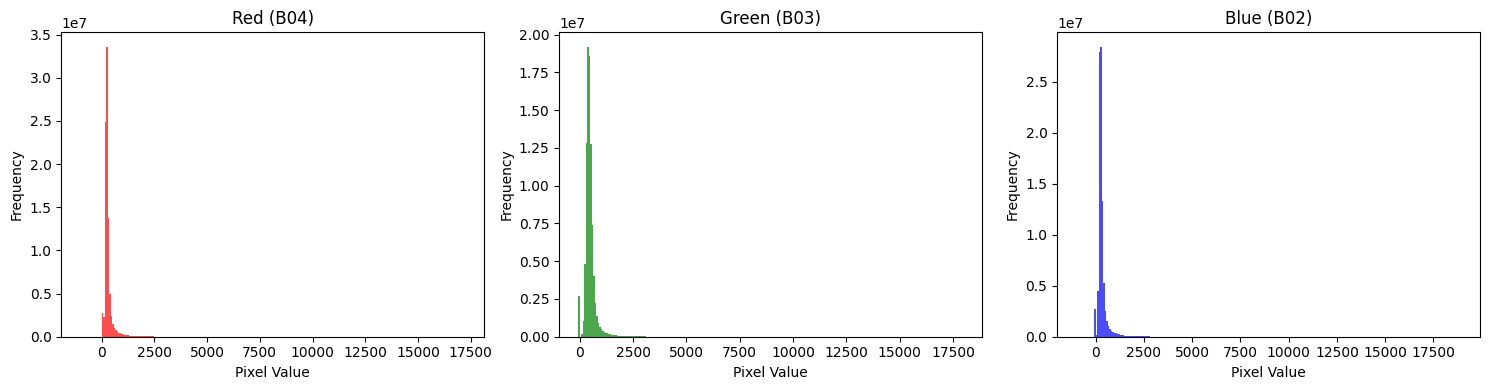

In [18]:
def plot_band_histograms(rgb):
    """
    Plots histograms for each band in the rgb array.
    rgb: np.ndarray of shape (3, H, W)
    """
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, rgb.shape[0], figsize=(15, 4))
    band_names = ["Red (B04)", "Green (B03)", "Blue (B02)"]
    for i in range(rgb.shape[0]):
        axes[i].hist(rgb[i].ravel(), bins=256, color=band_names[i].split()[0].lower(), alpha=0.7)
        axes[i].set_title(band_names[i])
        axes[i].set_xlabel("Pixel Value")
        axes[i].set_ylabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_band_histograms(rgb)

In [ ]:

rgb_uint8 = normalize_rgb_to_uint8(rgb)

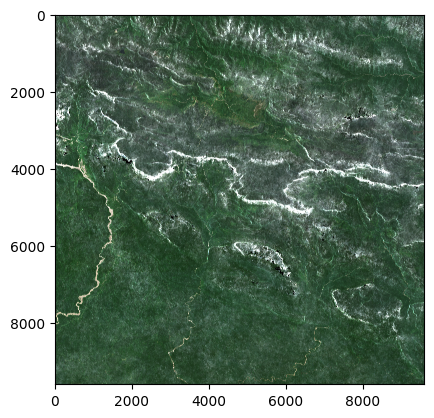

In [57]:
utils.imshow(rgb_uint8)

In [ ]:

def load_and_save_raster(src_path, save_path):
    """
    Loads a raster from src_path and saves it to save_path with empty meta.
    src_path: str or Path to source raster file
    save_path: str or Path to destination raster file
    """
    src_path = Path(src_path)
    save_path = Path(save_path)
    with rio.open(src_path) as src:
        data = src.read()
        save_raster(data, meta={'dtype': 'float32'}, save_path=save_path)

In [48]:
load_and_save_raster('/data/height_geomad_21_35.tif', '/data/height_geomad_21_35_nocrs.tif')

In [ ]:
from importlib import reload
reload(utils)


In [27]:
processor = utils.VegProcessor()

In [28]:
height = processor.process(rgb_uint8)

100%|██████████| 229/229 [02:44<00:00,  1.39it/s]


In [30]:
height.shape, height.max(), height.min()

((1, 9600, 9600), np.float32(27.8938), np.float32(0.0))

In [36]:
save_raster(height, meta={'dtype': 'float32'}, save_path =Path('/data/height_cloudless_21_35.tif'), nbits=None)

In [59]:
save_raster(rgb_uint8, meta={'dtype': 'uint8'}, save_path =Path('/data/geomad_21_35.tif'), nbits=8, overwrite=True)

file exists: /data/geomad_21_35.tif
Overwriting file...


In [38]:
rgb_uint8.min(), rgb_uint8.max()

(np.uint8(0), np.uint8(255))

In [13]:
allveg = processor.infer_veg_segmentation(im_, standardize=False)
allveg.shape


Creating patches...
Total 1369 patches.
Filtering all-zero patches...


100%|██████████| 1369/1369 [00:00<00:00, 13242.69it/s]


1369 patches remaining.

Finish initiation. Start inferencing...


100%|██████████| 229/229 [02:52<00:00,  1.33it/s]


(1, 9600, 9600)

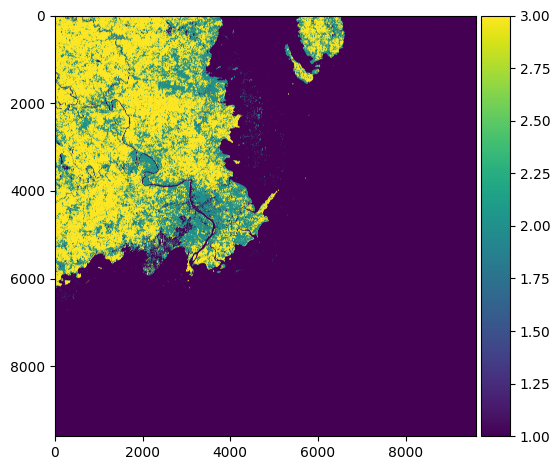

In [14]:
imshow(allveg)

In [15]:
nonvegmask = allveg <= 1
nonvegmask = np.repeat(nonvegmask, 3, axis=0)
im_[nonvegmask] = 0

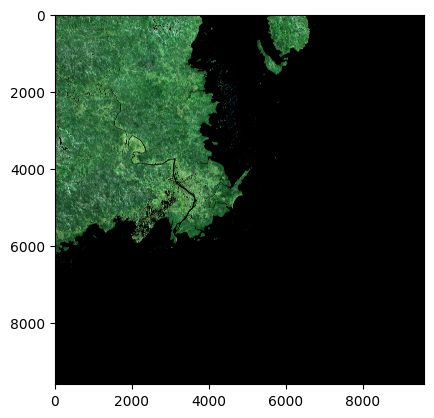

In [16]:
imshow(im_)

In [17]:
processor.mask = np.bitwise_and(processor.mask, ~nonvegmask[0])

In [12]:
height = processor.infer_height_estimation(im_, False)


Creating patches...
Total 1369 patches.
Filtering all-zero patches...


100%|██████████| 1369/1369 [00:00<00:00, 12267.32it/s]


1369 patches remaining.

start height inference
Finish initiation. Start inferencing...


100%|██████████| 229/229 [02:48<00:00,  1.36it/s]


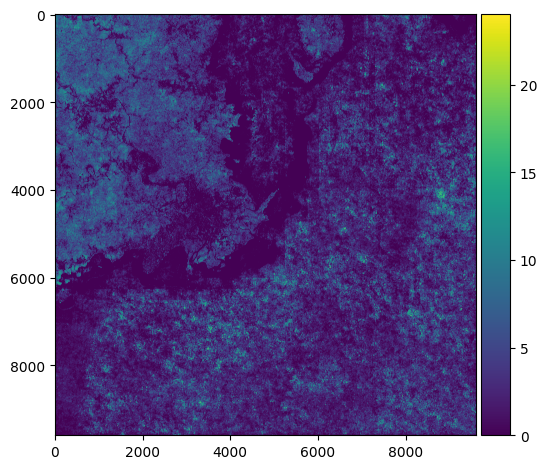

In [13]:
imshow(height)

In [42]:
height = processor.process(im_)

Preprocess input...
Step 1

Creating patches...
Total 1369 patches.
Filtering all-zero patches...


100%|██████████| 1369/1369 [00:00<00:00, 14146.07it/s]


1369 patches remaining.

Finish initiation. Start inferencing...


100%|██████████| 229/229 [04:25<00:00,  1.16s/it]


Step 2
step 3
standardize
patchify

Creating patches...
Total 1369 patches.
Filtering all-zero patches...


100%|██████████| 1369/1369 [00:00<00:00, 13794.40it/s]


1369 patches remaining.

start height inference
Finish initiation. Start inferencing...


100%|██████████| 229/229 [04:12<00:00,  1.10s/it]


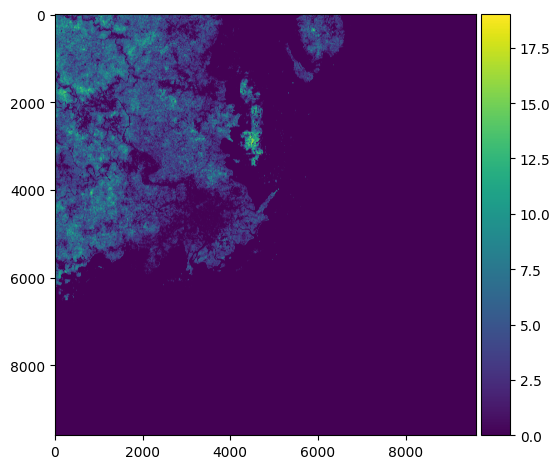

In [43]:
imshow(height)

+1 to zero valid pixels...


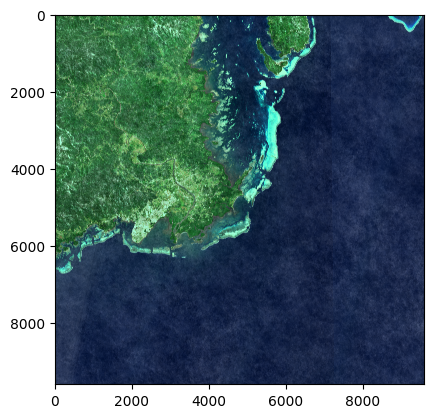

In [36]:
# data = data_np # shape [3,9600,9600]
# calculate alpha mask
if data.shape[0] == 3:
    mask = ~get_mask(data)[0]
    mask = mask.astype("uint8")
    # dilate then erode the mask to leave out the valid pixels with values = (0,0,0) inside the raster
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=1)
    mask = cv2.erode(mask, kernel, iterations=1)

elif data.shape[0] == 4:
    print(
        f"Fourth channel detected, which has min = {data[-1].min()}, max={data[-1].max()}. It will be treated as alpha channel"
    )
    mask = data[3].clip(max=1).astype("uint8")

for i in range(3):
    vmin, vmax = np.quantile(data[i], [0.001, 0.99])
    data[i] = data[i].clip(min=vmin, max=vmax)

rgb = data[:3].transpose([1, 2, 0])  # [h,w,3]
rgb = cv2.normalize(rgb, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)
rgb = rgb.transpose([2, 0, 1])  # [3,h,w]
final_data = np.empty((4, *data.shape[1:]), dtype=np.uint8)

print("+1 to zero valid pixels...")
# valid_zero_pixels = np.bitwise_and(utils.get_mask(rgb)[0], mask).astype('bool')
# print(valid_zero_pixels.sum())
rgb[rgb == 0] = 1
rgb = rgb * mask
final_data[:3] = rgb
final_data[3] = mask * 255

imshow(final_data[:3])

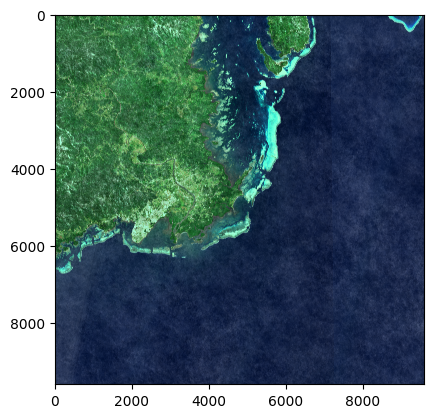

In [19]:
imshow(final_data[[0, 2, 1]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [140..1312].


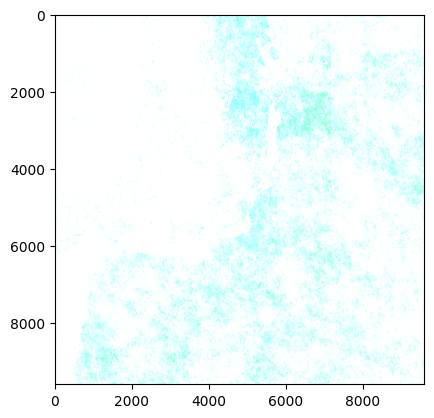

In [22]:
plt.imshow(data.transpose([1, 2, 0]))

In [ ]:
results = processor.process(data)

results

In [ ]:
import folium
from ipyleaflet import basemaps

masked = results.where(results.pc_deep < 0.7)  # ||  # Maybe use 0.5
masked_two = results.where(results.pc_pred > 0.1)

m = folium.Map(tiles=basemaps.Esri.WorldImagery)
m.fit_bounds(results.odc.map_bounds())

for var in results.data_vars:
    cmap = "Blues_r" if var in ("mean", "median", "depth") else "viridis"
    args = {
        "cmap": cmap,
    }
    if "pc" in var:
        args["vmin"] = 0
        args["vmax"] = 1
    results[var].odc.add_to(m, name=var, **args)

masked["mean"].odc.add_to(m, name="mean masked", cmap="Blues_r")
masked["median"].odc.add_to(m, name="median masked", cmap="Blues_r")

masked_two["mean"].odc.add_to(m, name="mean masked two", cmap="Blues_r")
masked_two["median"].odc.add_to(m, name="median masked two", cmap="Blues_r")

# Add a layer control to the map
folium.LayerControl().add_to(m)

m

In [ ]:
# results["pc_deep"].odc.write_cog("pc_deep_vanua.tif", overwrite=True)

In [ ]:
from dep_tools.namers import S3ItemPath

itempath = S3ItemPath(
    bucket="example-bucket",
    sensor="s2",
    dataset_id="sdb",
    version="9.9.9",
    time=datetime,
)